In [72]:
import pandas as pd
import selfies as sf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from collections import Counter
import seaborn as sns
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import csv
import selfies as sf
from collections import Counter
import torch.nn as nn
import csv
import os
import pandas as pd
from cddd.inference import InferenceModel
from cddd.preprocessing import preprocess_smiles
from scipy.ndimage import gaussian_filter

In [2]:
!python3 example/run_qsar_test.py --model_dir cddd/pretrained_models/default_model


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0613 06:16:56.941381 139179644823040 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Traceback (most recent call last):
  File "example/run_qsar_test.py", line 94, in <module>
    tf.app.run(main=main, argv=[sys.argv[0]] + UNPARSED)
  File "/home/undergrad/2026/melkoudi/miniconda3/envs/tf110/lib/p

In [3]:
!cddd --input smiles.smi --output descriptors.csv  --smiles_header smiles


/home/undergrad/2026/melkoudi/miniconda3/envs/tf110/lib/python3.6/site-packages/cddd/run_cddd.py:55: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  sml_df = pd.read_table(file, header=None).rename({0:FLAGS.smiles_header, 1:"EXTREG"},
Traceback (most recent call last):
  File "/home/undergrad/2026/melkoudi/miniconda3/envs/tf110/bin/cddd", line 8, in <module>
    sys.exit(main_wrapper())
  File "/home/undergrad/2026/melkoudi/miniconda3/envs/tf110/lib/python3.6/site-packages/cddd/run_cddd.py", line 99, in main_wrapper
    tf.app.run(main=main, argv=[sys.argv[0]] + UNPARSED)
  File "/home/undergrad/2026/melkoudi/miniconda3/envs/tf110/lib/python3.6/site-packages/tensorflow_core/python/platform/app.py", line 40, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "/home/undergrad/2026/melkoudi/miniconda3/envs/tf110/lib/python3.6/site-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/home/undergra

# Smiles Embedding:
### Use cddd to encode smiles (yippeeee)

In [11]:
# create a smiles list of 6000
smiles_list = []

with open("computed_spectra.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)  # skip header line
    for i, row in enumerate(reader):
        if i >= 6000:
            break
        smiles = row[0].strip()
        try:
            smiles_list.append(smiles)
        except:
            continue

# make instance of autoencoder model
inference_model = InferenceModel(model_dir="cddd/data/default_model")

# embed the smiles
smiles_embedding = inference_model.seq_to_emb(smiles_list)

# print example to see if it works
for i in range(5):
    print(f"SMILES: {smiles_list[i]}") # full smiles
    print(f"Embedding: {smiles_embedding[i][:10]}...\n")  # print first 10 values of the embedding



INFO:tensorflow:Restoring parameters from cddd/data/default_model/model.ckpt
SMILES: CN(c1ccc(NC(=O)Nc2ccccc2)cc1)S(=O)(=O)c1ccc(-c2ccn(CCO)n2)s1
Embedding: [-0.6485799  -0.4820745  -0.29993665  0.2840209  -0.19669785  0.23079348
 -0.45663777 -0.50177956 -0.06138841  0.28148285]...

SMILES: CC(O)CC(C)C#COC#CC(C)CC(C)O
Embedding: [-0.23311913 -0.62234724 -0.14250664  0.38820195  0.27778637 -0.15076475
  0.01024481 -0.58167255 -0.23104398 -0.5806556 ]...

SMILES: Cc1cc([N+](=O)[O-])ccc1NC(=O)c1ccc(OCC(C)C)c(Br)c1
Embedding: [-0.47915938 -0.5277588   0.254828   -0.35512787 -0.01809985  0.02691496
 -0.17222045 -0.12126444  0.45158276  0.21312533]...

SMILES: COC12C(COC(N)=O)C3=C(C(=O)C(C)=C(N)C3=O)N1CC1NC12
Embedding: [ 0.95607096 -0.4094612   0.5092193   0.33736256  0.11703882  0.35932195
  0.7206423  -0.6761475  -0.16922899  0.69493043]...

SMILES: CC(C)(O)C(NC(=O)c1cnn2cc(C3CC3)cnc12)c1ccc(OC(F)(F)F)c(F)c1
Embedding: [-0.8880903   0.08556144  0.20473011  0.1794778   0.02583974 -0.440634

# Normalize & Smooth Spectra

In [13]:
import numpy as np
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler


spec_len = 1801 
spectra_list = []

with open("computed_spectra.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)
    for i, row in enumerate(reader):
        if i >= 6000:
            break
        try:
            spectrum = [float(x) for x in row[1:]]
            if len(spectrum) == spec_len:
                spectra_list.append(spectrum)
        except:
            continue


# conver to np array
spectra_array = np.array(spectra_list)

# normalize
scaler = MinMaxScaler()
normalized_spectra = scaler.fit_transform(spectra_array)

# check if normalization worked 
print("Normalized spectra shape:", normalized_spectra.shape)
print("Sample normalized spectrum:", normalized_spectra[0][:10])

# Smooth each spectrum
smoothed_spectra = [savgol_filter(spectrum, window_length=15, polyorder=3) for spectrum in normalized_spectra]

# covert back to np array
smoothed_spectra = np.array(smoothed_spectra)
Y = smoothed_spectra 

# check if smoothing worked
print("Smoothed spectra shape:", smoothed_spectra.shape)
print("Example smoothed spectrum:", smoothed_spectra[0][:10])


Normalized spectra shape: (3568, 1801)
Sample normalized spectrum: [0.10808033 0.10908509 0.1097319  0.11094673 0.11241841 0.11278684
 0.11332587 0.11278429 0.11410056 0.11418134]
Smoothed spectra shape: (3568, 1801)
Example smoothed spectrum: [0.10755056 0.10928005 0.11052331 0.11138647 0.11197562 0.11239689
 0.11275636 0.11316016 0.11389765 0.11500437]


# Pad Smiles

In [49]:
"""def pad_embeddings(embeddings, target_dim=1802):
    current_dim = embeddings.shape[1]
    if current_dim >= target_dim:
        return embeddings[:, :target_dim]  # truncate if too long
    padding = np.ones((embeddings.shape[0], target_dim - current_dim*2))*2
    return np.concatenate([embeddings, padding, embeddings], axis=1)

X_padded = pad_embeddings(smiles_embedding, target_dim=1802)  # shape (6000, 1801)
"""

"""def pad_to_even_dim(arr, target_dim=1802):
    if arr.shape[1] < target_dim:
        padding = np.ones((arr.shape[0], target_dim - arr.shape[1]))
        return np.concatenate([arr, padding], axis=1)
    else:
        return arr[:, :target_dim]"""

import numpy as np
"""
def pad_embeddings(embeddings, target_dim=1802):
    
    Pads embeddings by placing a zero-filled gap between two copies of the embeddings.
    Final shape: [embeddings | zeros | embeddings]
    
    current_dim = embeddings.shape[1]
    if 2 * current_dim > target_dim:
        raise ValueError(f"Embedding dimension too large for target_dim. Got {current_dim}, expected ≤ {target_dim//2}")
    
    gap_dim = target_dim - 2 * current_dim
    zeros = np.ones((embeddings.shape[0], gap_dim))
    return np.concatenate([embeddings, zeros, embeddings], axis=1)
    """

def pad_embeddings(embeddings, target_dim=1802):
    current_dim = embeddings.shape[1]
    if 2 * current_dim > target_dim:
        raise ValueError(f"Embedding dimension too large for target_dim. Got {current_dim}, expected ≤ {target_dim//2}")
    
    gap_dim = target_dim - 2 * current_dim
    zeros = np.zeros((embeddings.shape[0], gap_dim))  # ✅ use zeros
    return np.concatenate([embeddings, zeros, embeddings], axis=1)


# Split into train & test sets :)

In [50]:
from sklearn.model_selection import train_test_split

# Make sure X and Y have the same number of samples
min_len = min(len(X_padded), len(Y))
X_padded = X_padded[:min_len]
Y = Y[:min_len]

# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X_padded, Y, test_size=0.2, random_state=42)

# Combine for INN input
Z_train = np.concatenate([X_train, Y_train], axis=1)
Z_test = np.concatenate([X_test, Y_test], axis=1)

print("Z_train shape:", Z_train.shape)
print("Z_test shape:", Z_test.shape)


Z_train shape: (2854, 3603)
Z_test shape: (714, 3603)


# Dataset:

In [51]:
from torch.utils.data import Dataset, DataLoader
import torch

class SmilesSpectraDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

# DataLoaders
train_loader = DataLoader(SmilesSpectraDataset(Z_train), batch_size=64, shuffle=True)
test_loader = DataLoader(SmilesSpectraDataset(Z_test), batch_size=64)

In [21]:
sample = torch.tensor(Z_train[0][:1802], dtype=torch.float32).reshape((-1, 1802))
print(sample.shape)
sample2 = torch.rand((32, 1802))
print(sample[:,512:1024])
model(sample2)



torch.Size([1, 1802])
tensor([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
      

NameError: name 'model' is not defined

In [52]:
class SIDLoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps

    def forward(self, model_spectra, target_spectra):
        model_spectra = torch.clamp(model_spectra, min=self.eps)
        target_spectra = torch.clamp(target_spectra, min=self.eps)

        term1 = model_spectra * torch.log(model_spectra / target_spectra)
        term2 = target_spectra * torch.log(target_spectra / model_spectra)
        loss = term1 + term2
        return loss.sum(dim=1).mean()

In [23]:

    for batch in train_loader:
        break
    x_batch = batch[:, :1802]
    y_batch = batch[:, 1802:]
    optimizer.zero_grad()
    y_pred = model(x_batch)
    print(y_pred[:, 900:])

NameError: name 'optimizer' is not defined

# INN Model: (RealNVP)

In [42]:
class CouplingLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()
        hidden = 512
        self.scale = nn.Sequential(
         nn.Linear(dim // 2, hidden),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(hidden, dim // 2),
        nn.Tanh()  # keeps scale factor in range (-1, 1)
        )       

        self.translate = nn.Sequential(
            nn.Linear(dim // 2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, dim // 2),
            nn.ReLU()
        )
    def forward(self, x, reverse=False):
        x1, x2 = x.chunk(2, dim=1)
        s, t = self.scale(x1), self.translate(x1)
        y2 = x2 * torch.exp(s) + t if not reverse else (x2 - t) * torch.exp(-s)
        return torch.cat([x1, y2], dim=1)

class RealNVP(nn.Module):
    def __init__(self, dim, num_layers=3):
        super().__init__()
        self.layers = nn.ModuleList([CouplingLayer(dim) for _ in range(num_layers)])
    def forward(self, x, reverse=False):
        for layer in (self.layers if not reverse else reversed(self.layers)):
            x = layer(x, reverse=reverse)
        return x

class RealNVPWithProjection(nn.Module):
    def __init__(self, dim, output_dim=1801, num_layers=3):
        super().__init__()
        self.flow = RealNVP(dim, num_layers)
        self.project = nn.Sequential(
            nn.Linear(dim, output_dim),
            nn.Tanh()  # ✅ squash values between -1 and 1
        )

    def forward(self, x, reverse=False):
        x = self.flow(x, reverse=reverse)
        if not reverse:
            x = self.project(x)
        return x



# Training Loop

In [60]:
input_dim = 1802
model = RealNVPWithProjection(dim=1802, output_dim=1801, num_layers=10)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

train_losses = []
test_losses = []

for epoch in range(20):
    model.train()
    total_loss = 0
    for batch in train_loader:
        x_batch = batch[:, :1802]
        y_batch = batch[:, 1802:]
        optimizer.zero_grad()
        y_pred = model(x_batch)
        #loss = loss_fn(y_pred[:, :1801], y_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss)

    model.eval()
    with torch.no_grad():
        test_loss = 0
        for batch in test_loader:
            x_batch = batch[:, :1802]
            y_batch = batch[:, 1802:]
            y_pred = model(x_batch)
            test_loss += loss_fn(y_pred, y_batch).item()
        test_losses.append(test_loss)

    print(f"Epoch {epoch+1}: Train Loss = {total_loss:.4f}, Test Loss = {test_loss:.4f}")


Epoch 1: Train Loss = 11.0708, Test Loss = 0.2835
Epoch 2: Train Loss = 0.9304, Test Loss = 0.2016
Epoch 3: Train Loss = 0.7054, Test Loss = 0.1685
Epoch 4: Train Loss = 0.5879, Test Loss = 0.1462
Epoch 5: Train Loss = 0.5101, Test Loss = 0.1304
Epoch 6: Train Loss = 0.4520, Test Loss = 0.1180
Epoch 7: Train Loss = 0.4079, Test Loss = 0.1087
Epoch 8: Train Loss = 0.3732, Test Loss = 0.1009
Epoch 9: Train Loss = 0.3454, Test Loss = 0.0946
Epoch 10: Train Loss = 0.3219, Test Loss = 0.0897
Epoch 11: Train Loss = 0.3044, Test Loss = 0.0853
Epoch 12: Train Loss = 0.2876, Test Loss = 0.0817
Epoch 13: Train Loss = 0.2750, Test Loss = 0.0788
Epoch 14: Train Loss = 0.2636, Test Loss = 0.0763
Epoch 15: Train Loss = 0.2547, Test Loss = 0.0738
Epoch 16: Train Loss = 0.2461, Test Loss = 0.0720
Epoch 17: Train Loss = 0.2380, Test Loss = 0.0701
Epoch 18: Train Loss = 0.2314, Test Loss = 0.0687
Epoch 19: Train Loss = 0.2263, Test Loss = 0.0673
Epoch 20: Train Loss = 0.2211, Test Loss = 0.0665


In [78]:
input_dim = 1802
model = RealNVP(dim=input_dim, num_layers=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = SIDLoss()

In [82]:
s1 = torch.rand((32,1802))
s1 = s1/10000
model(s1)

tensor([[2.6505e-05, 8.1909e-05, 6.1232e-05,  ..., 2.8554e-02, 3.7877e-02,
         7.7821e-03],
        [4.7800e-05, 3.7571e-05, 1.8801e-05,  ..., 2.8569e-02, 3.7874e-02,
         7.7865e-03],
        [2.5125e-05, 6.3787e-05, 4.0418e-05,  ..., 2.8524e-02, 3.7803e-02,
         7.7103e-03],
        ...,
        [6.6687e-05, 5.6700e-05, 8.4251e-05,  ..., 2.8569e-02, 3.7921e-02,
         7.7148e-03],
        [9.0995e-05, 5.4451e-05, 9.9603e-05,  ..., 2.8514e-02, 3.8144e-02,
         7.7443e-03],
        [6.6049e-05, 2.5114e-05, 3.3071e-05,  ..., 2.8600e-02, 3.8140e-02,
         7.7509e-03]], grad_fn=<CatBackward>)

# Model Evaluation 

NameError: name 'val_losses' is not defined

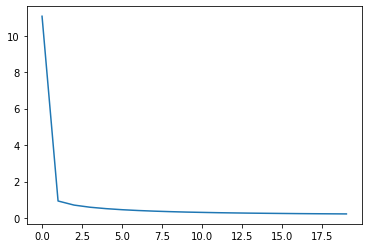

In [61]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.plot(test_losses, label="Test")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

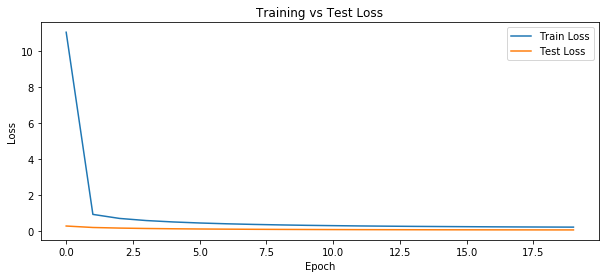

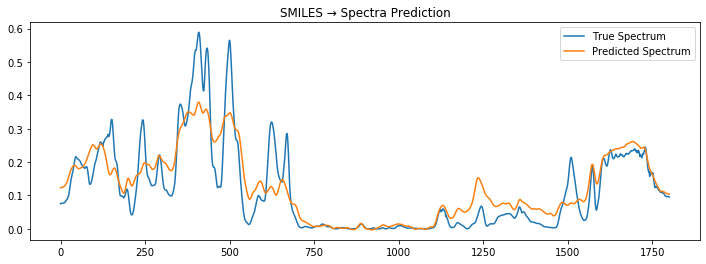

In [75]:
# plot loss graph
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.show()

# plot predicted vs true spectrum
model.eval()
with torch.no_grad():
    y_pred_test = model(torch.tensor(X_test, dtype=torch.float32)).numpy()

y_pred_test = gaussian_filter(y_pred_test, sigma=5)

idx = 21
plt.figure(figsize=(12, 4))
plt.plot(Y_test[idx], label="True Spectrum")
plt.plot(y_pred_test[idx], label="Predicted Spectrum")
plt.title("SMILES → Spectra Prediction")
plt.legend()
plt.show()
